# Artifact 7: Multiple Traveling Salesman Problem

In [1]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In Artifact 6, we looked at solving the Traveling Salesman Problem (TSP) for a single salesman. In this artifact, I will show how to solve the Multiple Traveling Salesman Problem (mTSP) using CVXPY. This artifact adds another dimension to the work done in Artifact 6.

Let's first tweak the Mathematical Problem formulation to represent $m$ salesmen. 

## Mathematical Problem

The problem considers $m$ traveling salesmen. To solve it, I'm going to use the Miller-Tucker-Zemlin formulation, which follows:

The nodes are identified with the numbers $1, \ldots, n$, with which we define:

$$
x_{ij} = \begin{cases} 1 & \text{the path goes from the node} \, i \text{ to node } j \\ 0 & \text{otherwise} \end{cases}
$$

For $i = 1, \ldots, n$, $m$ is the number of salesmen, $u_{i}$ is an auxiliary variable and $c_{i, j}$ is the distance from node $i$ to the node $j$. Then the mTSP can be written as the following integer linear programming problem:

$$
\begin{align}
\min &\sum_{i=1}^n \sum_{j\ne i,j=1}^n c_{i,j}x_{i,j}\colon &&  \\
     & \sum_{i=2}^n x_{i,1} = m \\
     & \sum_{j=2}^n x_{1,j} = m \\
     & \sum_{i=2,i\ne j}^n x_{i,j} = 1 && j=1, \ldots, n; \\
     & \sum_{j=2,j\ne i}^n x_{i,j} = 1 && i=1, \ldots, n; \\
     & u_{i}-u_{j} + 1 \le (n-1)(1-x_{i,j}) && 2 \le i \ne j \le n;  \\
     & 0 \le u_{i} \le n && 2 \le i \le n; \\
     & x_{i,j} \in \{0,1\}  && i,j=1, \ldots, n; \\
     & u_{i} \in \mathbf{Z} && i=2, \ldots, n. \\
\end{align}
$$

The objective function minimizes the distance of each salesman's routes. The first two restrictions guarantee that there is a number of salesmen $m$ who leave and return to the node of origin. The following two restrictions ensure that each node is reached from exactly one other node and that from each node there is an exit to exactly one other node. The constraints of the auxiliary variables force that no salesman passes through the same node twice.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import cvxpy as cp
from geopy.distance import geodesic
from scipy.optimize import linprog
from scipy.spatial.distance import euclidean

In [3]:
nodes = pd.read_csv("stations.csv",index_col=0)

In [4]:
nodes.head()

,name,x,y
index,,,
0,Downtown,-123.121405,49.280311
1,HastingsClark,-123.077084,49.281288
2,BoundaryHastings,-123.023351,49.281132
3,MainTerminal,-123.099939,49.272719
4,Clark1st,-123.077314,49.269678


In [5]:
edges = pd.read_csv("routes.csv")

In [6]:
edges.head()

,from,to
0,5,2
1,5,4
2,5,12
3,2,5
4,2,1


In [7]:
G = nx.DiGraph()

In [8]:
G.add_nodes_from(nodes.index)

In [9]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24))

In [10]:
coordinates = []
for i in nodes.index:
    x = nodes.iloc[i,1]
    y = nodes.iloc[i,2]
    coordinates.append((x,y))

In [11]:
for i in edges.index:
    source = edges.iloc[i,0]
    target = edges.iloc[i,1]
    G.add_edge(source,target,capacity=10)

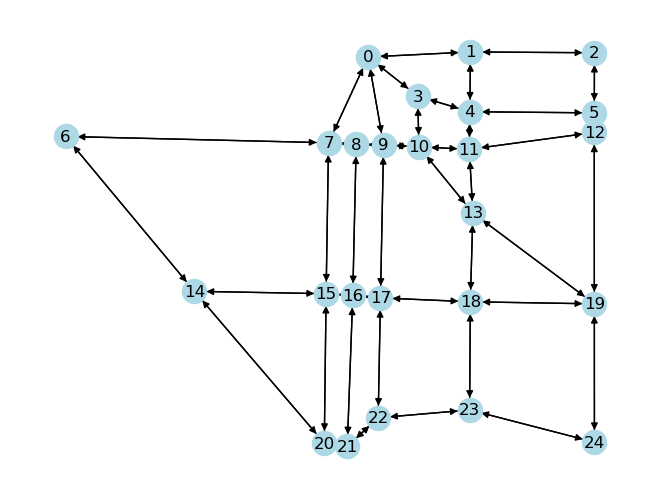

In [12]:
nx.draw(G,pos=coordinates,
        with_labels=True,
        node_color='lightblue')

In [13]:
n = G.number_of_nodes()
C = np.zeros((n, n)) 

for i in range(n):
    for j in range(n):
        if i != j:
            coord_i = nodes.loc[i, ['x', 'y']]
            coord_j = nodes.loc[j, ['x', 'y']]
            C[i, j] = euclidean(coord_i, coord_j)

# Showing distance matrix
print('Distance Matrix is:\n')
print(np.round(C,4))

Distance Matrix is:

[[0.     0.0443 0.0981 0.0228 0.0454 0.0986 0.132  0.0239 0.0177 0.0183
  0.0281 0.0473 0.0991 0.0546 0.0879 0.0495 0.0468 0.0471 0.065  0.1091
  0.0773 0.0762 0.0702 0.0814 0.1233]
 [0.0443 0.     0.0537 0.0244 0.0116 0.055  0.1762 0.064  0.0526 0.0417
  0.0289 0.0189 0.0559 0.0313 0.1283 0.0782 0.0695 0.0617 0.0485 0.0726
  0.0989 0.0934 0.0815 0.0695 0.0929]
 [0.0981 0.0537 0.     0.077  0.0552 0.0117 0.2297 0.1165 0.1047 0.0931
  0.0782 0.0574 0.0155 0.0612 0.1794 0.1253 0.1148 0.1042 0.0723 0.0488
  0.1394 0.1316 0.1175 0.088  0.0756]
 [0.0228 0.0244 0.077  0.     0.0228 0.0766 0.1528 0.0397 0.0282 0.0176
  0.0099 0.0246 0.0768 0.033  0.1039 0.0552 0.0478 0.0424 0.046  0.0865
  0.0786 0.0746 0.0648 0.065  0.1019]
 [0.0454 0.0116 0.0552 0.0228 0.     0.0539 0.1752 0.0615 0.0497 0.038
  0.0231 0.0073 0.054  0.0197 0.1243 0.0716 0.062  0.053  0.0369 0.0656
  0.0901 0.0839 0.0715 0.0579 0.0838]
 [0.0986 0.055  0.0117 0.0766 0.0539 0.     0.2291 0.1153 0.1033 0.091

## Example for three Traveling Salesmen

Continuing with work done in Artifact 6, now we are going to find the optimal paths (shortest distance) for three salesmen that start from the point of origin (0) and between all of them must go through points 1 to 24 and return to point 0.

In [14]:
# Defining the variables
X = cp.Variable(C.shape, boolean=True)
u = cp.Variable(n, integer=True)
m = 3
ones = np.ones((n,1))

# Defining the objective function
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

# Defining the constraints
constraints = []
constraints += [X[0,:] @ ones == m]
constraints += [X[:,0] @ ones == m]
constraints += [X[1:,:] @ ones == 1]
constraints += [X[:,1:].T @ ones == 1]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Transforming the solution to paths
X_sol = np.argwhere(X.value==1)

ruta = {}
for i in range(0, m):
    ruta['Salesman_' + str(i+1)] = [0]
    j = i
    a = 10e10
    while a != 0:
        a = X_sol[j,1]
        ruta['Salesman_' + str(i+1)].append(a)
        j = np.where(X_sol[:,0] == a)
        j = j[0][0]
        a = j

# Showing the paths
for i in ruta.keys():
    print('The path of ' + i + ' is:\n')
    print( ' => '.join(map(str, ruta[i])))
    print('')

The path of Salesman_1 is:

0 => 3 => 10 => 13 => 11 => 4 => 1 => 2 => 5 => 12 => 19 => 24 => 23 => 18 => 17 => 16 => 15 => 22 => 21 => 20 => 14 => 6 => 7 => 0

The path of Salesman_2 is:

0 => 8 => 0

The path of Salesman_3 is:

0 => 9 => 0



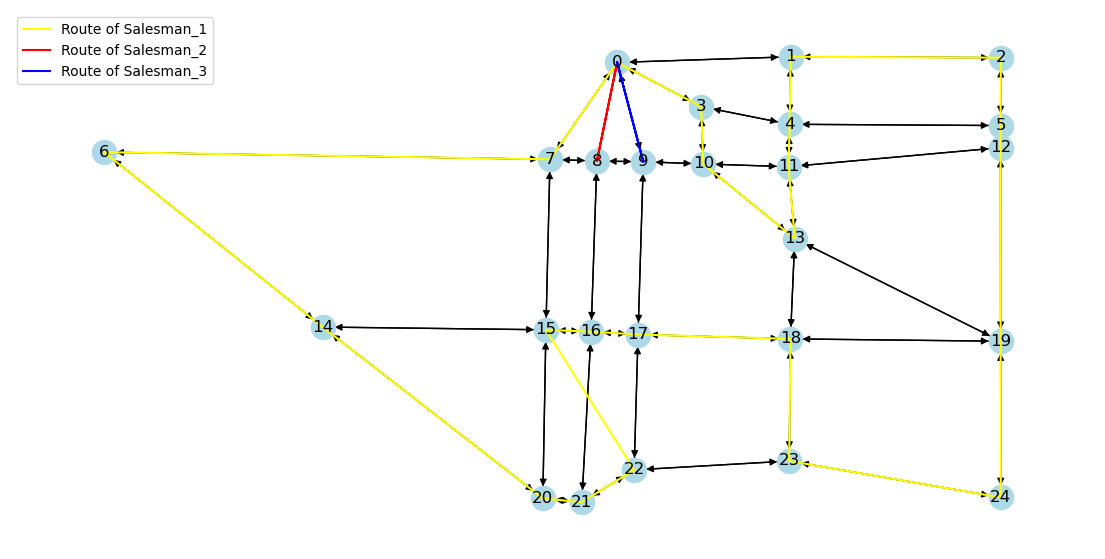

In [24]:
fig, ax = plt.subplots(figsize=(14, 7))

pos = {node: (x, y) for node, (x, y) in zip(nodes.index, coordinates)}
nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', ax=ax)

colors = ['yellow', 'red', 'blue'] 
for idx, (salesman, route) in enumerate(ruta.items()):
    path_coords = [pos[node] for node in route]
    xs, ys = zip(*path_coords)
    ax.plot(xs, ys, color=colors[idx % len(colors)], label=f'Route of {salesman}')
    ax.scatter(xs, ys, color=colors[idx % len(colors)])  # Plot points for clarity

ax.legend()
plt.show()

In [23]:
distance = np.sum(np.multiply(C, X.value))
print('The optimal distance is:', np.round(distance,2), 'units')

The optimal distance is: 0.75 units


It can be observed that depending on the location of the points that salesmen must travel, in terms of distance it may not be optimal to add more salesmen.

This becomes clearly evident when we observed the optimal distance for a single salesman to be 0.7 units as compared to the 0.75 units of the 3 salesmen.

The fact that the optimal route suggests 1 salesman to travel most of the distance as compaared to the other 2 suggests that this route s better suited for lesser salesmen.

Running a TSP problem with cvxpy on syzygy is computationally expensive. Both, Artifact 6 and Artifact 7, took over 30 minutes to run. This significantly hindered the amount of further analysis I could conduct.

### Next Steps for Further Analysis

1. Introduce parallel processing (ideally, on an advanced computer) on a local python environment.
2. Run the mTSP problem for a range of $m$ salesmen to graph how the optimal travel distance changes with each iteration.
3. Problem analysis with different routes to develop an intuitive understanding of which route might need more salesmen, and the routes that may not.
4. Compare cvxpy results with Networkx' in-built `traveling_salesman_problem()` function.
5. Compare cvxpy with routing greedy algorithm, integer programming in terms of accuracy and computational speed.

## References

- CVXPY. *CVXPY: A Python-Embedded Modeling Language for Convex Optimization Problems*. Retrieved from [https://www.cvxpy.org/](https://www.cvxpy.org/)
- NEOS Guide. *Multiple Traveling Salesman Problem (MTSP)*. Retrieved from [https://neos-guide.org/case-studies/tra/multiple-traveling-salesman-problem-mtsp/](https://neos-guide.org/case-studies/tra/multiple-traveling-salesman-problem-mtsp/)
- Co-Enzyme. *Traveling Salesman Problem (TSP) in CPLEX OPL with Miller-Tucker-Zemlin (MTZ) formulation*. Retrieved from [https://co-enzyme.fr/blog/traveling-salesman-problem-tsp-in-cplex-opl-with-miller-tucker-zemlin-mtz-formulation/](https://co-enzyme.fr/blog/traveling-salesman-problem-tsp-in-cplex-opl-with-miller-tucker-zemlin-mtz-formulation/)
- NetworkX Developers. NetworkX Reference Documentation [Software documentation]. NetworkX. [https://networkx.org/documentation/stable/reference/index.html](https://networkx.org/documentation/stable/reference/index.html)
- OpenAI. ChatGPT [Software]. Available from https://openai.com/chatgpt